In [1]:
from functools import partial

from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from pit import *

In [2]:
%matplotlib widget

In [3]:
def pit_hist(ax, x, n_bins, **kwargs):
    ax.hist(x, range=(0, 1), bins=n_bins, **kwargs)

def pit_stairs(ax, x, n_bins, **kwargs):
    ax.stairs(x, np.linspace(0, 1, n_bins + 1), **kwargs)

In [4]:
def get_grid():
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2, 2)
    ax = fig.add_subplot(gs[0, :])
    ax_true = fig.add_subplot(gs[1, 0])
    ax_pred = fig.add_subplot(gs[1, 1])
    return fig, ax, ax_true, ax_pred

def plot_pred_press(event, ax, model, plot_function):
    x = float(event.xdata)
    y = float(event.ydata)
    if x is not None and y is not None:
        ax.clear()
        x_pred = model.decoder.decode(torch.tensor([[x, y]]))[0]
        plot_function(ax, x_pred, label=f"({x:.4f}, {y:.4f})")
        ax.legend()
        fig.canvas.draw()

def plot_true_pick(event, ax, dataset, model, plot_function):
    idx = event.ind[0]
    ax.clear()
    # true
    x, y = dataset.X[idx], dataset.y[idx]
    plot_function(ax, x, label=repr(y))
    # reconstruction
    mu, sigma = model.embed(x.unsqueeze(0))
    x_pred = model.decoder.decode(mu)[0]
    plot_function(ax, x_pred)
    ax.legend()
    fig.canvas.draw()

## Data

In [5]:
REPEATS = 10
SAMPLES = 10000

In [6]:
seed()
data_train = generate_data(REPEATS, SAMPLES)
data_test = generate_data(1, SAMPLES)
colors = ["red" if type(a[1]) is Normal else "green" for a in data_train[1]]
trainset, testset = PITHistDataset(*data_train, BINS), PITHistDataset(*data_test, BINS)
len(trainset), len(testset)

(800, 80)

## Variational AutoEncoder

In [7]:
vae = VAE(input_dim=BINS, n_hiddens=16, epsilon=None)
vae.load_state_dict(torch.load("models/fast-cloud-4336.pt"))
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): Tanh()
      (4): Linear(in_features=16, out_features=10, bias=True)
      (5): Softmax(dim=1)
    )
  )
)

In [8]:
mu_train, sigma_train = vae.embed(trainset.X)
X_pred_train = vae.decoder.decode(mu_train)
error = square_error(X_pred_train, trainset.X)
error.min(), error.max()

(tensor(6.6428e-06), tensor(0.0066))

16

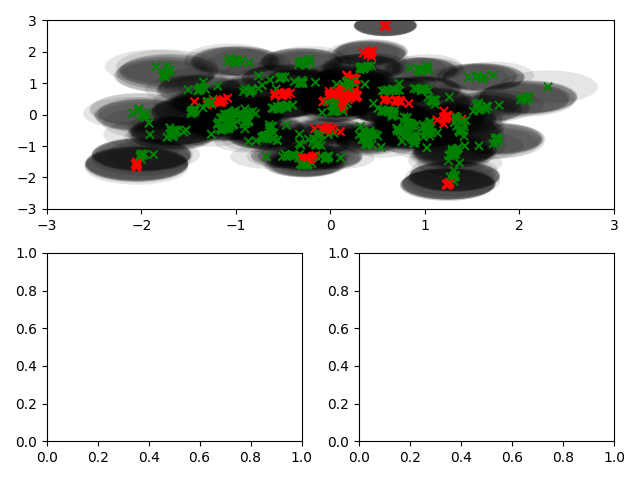

In [10]:
fig, ax, ax_true, ax_pred = get_grid()

for i in range(len(trainset)):
    size = 3 * sigma_train[i]
    e = Ellipse(xy=mu_train[i], width=size, height=size)
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.1)
    e.set_facecolor("k")

ax.scatter(mu_train[:, 0], mu_train[:, 1], c=colors, marker="x", picker=True)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plot_function = partial(pit_stairs, n_bins=BINS)
fig.canvas.mpl_connect(
    "pick_event",
    partial(plot_true_pick, ax=ax_true, dataset=trainset, model=vae, plot_function=plot_function))
fig.canvas.mpl_connect(
    "button_press_event",
    partial(plot_pred_press, ax=ax_pred, model=vae, plot_function=plot_function))

In [11]:
d = torch.full((1, 10), 0.1)
a, b = vae.embed(d)
a, b

(tensor([[0.1343, 0.6351]]), tensor([[0.2571]]))

In [12]:
c = vae.decoder.decode(a)
c

tensor([[0.0963, 0.1019, 0.0980, 0.0991, 0.1016, 0.1024, 0.1010, 0.1005, 0.1017,
         0.0974]])

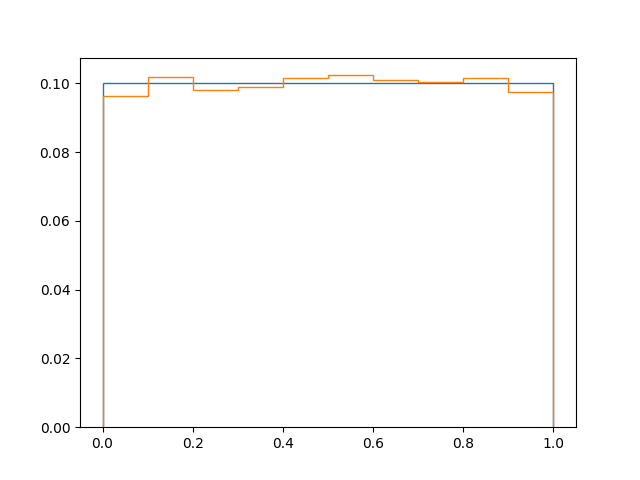

In [13]:
_, ax = plt.subplots()
pit_stairs(ax, d[0], BINS)
pit_stairs(ax, c[0], BINS)